# Alex Sessums & Valentin Lorenzen

In [671]:
# Data Analysis
import numpy as np
import pandas as pd
# Miscellaneous
import os
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1.5)
import matplotlib.ticker as mtick
sns.set_style("dark")

In [672]:
# Load Data from Text File into Dataframe
df = pd.read_csv('data/friday.csv', sep=';', header=1)
df = df[:-5128]

In [673]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['customer_no'] = df['customer_no'].astype(int)
df['hour'] = df['timestamp'].dt.hour

### Calculate the time each customer spent in the market

In [692]:
total_customer_time = pd.DataFrame()

total_customer_time['total_time_spend'] = df.groupby('customer_no').last()['timestamp'] - df.groupby('customer_no').first()['timestamp']

for row in total_customer_time.iterrows():
    if row[1][0] == pd.Timedelta("0 days 00:00:00"):
        total_customer_time['total_time_spend'][row[0]] = pd.to_datetime("2019-09-06 22:00:00") - df.groupby('customer_no').first()['timestamp'][row[0]]

total_customer_time['minutes'] = total_customer_time['total_time_spend'].dt.total_seconds()/60
total_customer_time['minutes'] = total_customer_time['minutes'].astype(int)

# Print spent time for n customer
def print_customer_spent_time (customer_no):
    try:       
        print ('Customer #', customer_no, 'stayed for', total_customer_time['minutes'][customer_no], 'minutes')
    except:
        print ('Customer not in database')


print_customer_spent_time(99)
print_customer_spent_time(1298)
print_customer_spent_time(1)
print_customer_spent_time(5198)


Customer # 99 stayed for 7 minutes
Customer # 1298 stayed for 2 minutes
Customer # 1 stayed for 5 minutes
Customer not in database


In [675]:
minute_groups = []

for x in total_customer_time['minutes']:
    if x <= 5:
        minute_groups.append("1 - 5 Minutes")
    elif x <=10:
        minute_groups.append("6 - 10 Minutes")
    elif x <=15:
        minute_groups.append("11 - 15 Minutes")
    elif x <=20:
        minute_groups.append("16 - 20 Minutes")
    elif x > 20:
        minute_groups.append("Longer than 20 minutes")

total_customer_time['minutes_groups'] = minute_groups

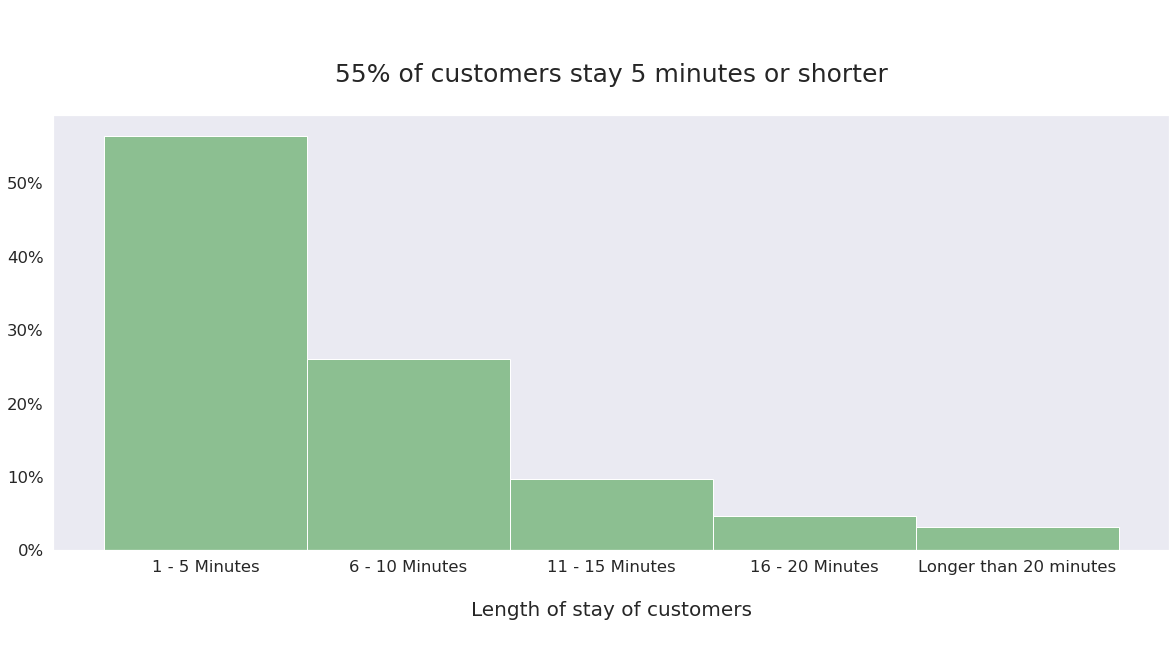

In [676]:
fig = plt.gcf()
fig.set_size_inches(20,8)
total_customer_time['minutes_groups'] = pd.Categorical(total_customer_time['minutes_groups'], ['1 - 5 Minutes','6 - 10 Minutes','11 - 15 Minutes','16 - 20 Minutes', 'Longer than 20 minutes'])
p = sns.histplot(data=total_customer_time['minutes_groups'].sort_values(), stat='percent', color="green", alpha=0.4)
p.yaxis.set_major_formatter(mtick.PercentFormatter())
p.set_xlabel("\nLength of stay of customers\n\n", fontsize = 20)
p.set_ylabel("")
p.set_title("\n\n55% of customers stay 5 minutes or shorter\n", fontsize = 25);

### Calculate the total number of customers in the supermarket over time.

In [677]:
counter = 0
current_customers = []
df['current_customers'] = 0

for row in df.iterrows():
    if row[1][2] != 'checkout' and row[1][1] not in current_customers:
        counter += 1
        df['current_customers'][row[0]] = counter
        current_customers.append(row[1][1])
        
    if row[1][2] == 'checkout':
        counter -= 1
        df['current_customers'][row[0]] = counter

    else:
        df['current_customers'][row[0]] = counter

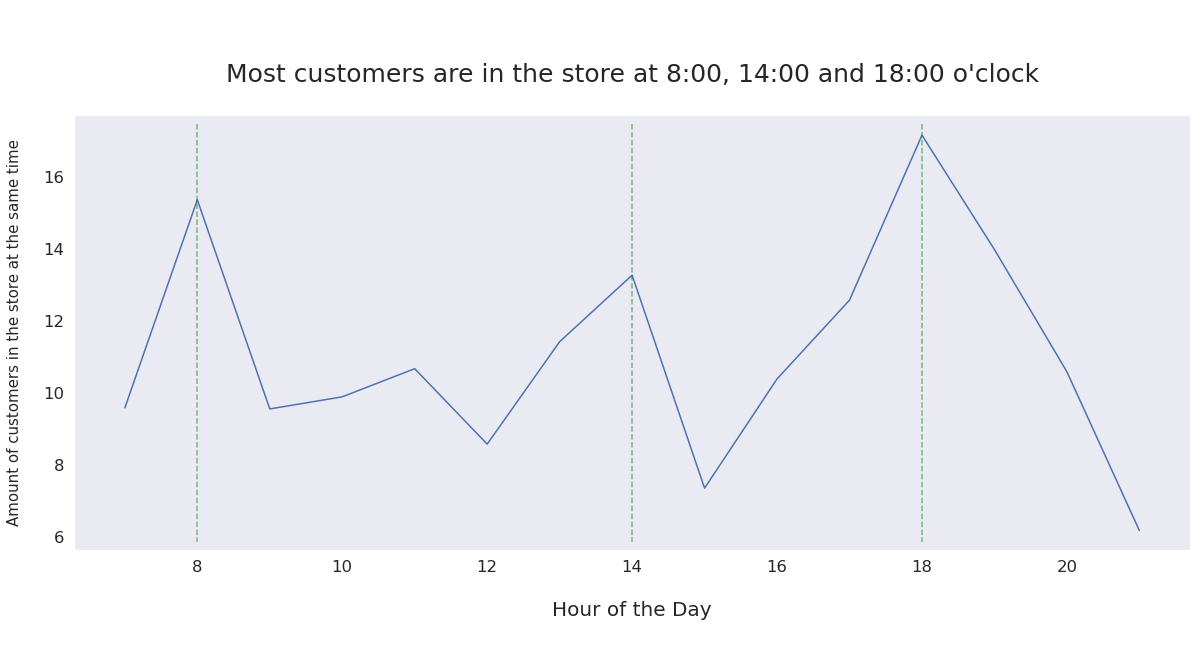

In [678]:
fig = plt.gcf()
fig.set_size_inches(20,8)
p = sns.lineplot(data=df.groupby('hour')['current_customers'].mean())
p.set_xlabel("\nHour of the Day\n", fontsize = 20)
p.set_ylabel("Amount of customers in the store at the same time\n", fontsize = 15)
line1 = plt.axvline(8, 0.98,0.02, color='green', linestyle="--", alpha=0.5)
line2 = plt.axvline(14,0.98,0.02, color='green', linestyle="--", alpha=0.5)
line3 = plt.axvline(18,0.98,0.02, color='green', linestyle="--", alpha=0.5)
p.set_title("\n\nMost customers are in the store at 8:00, 14:00 and 18:00 o'clock\n", fontsize = 25);

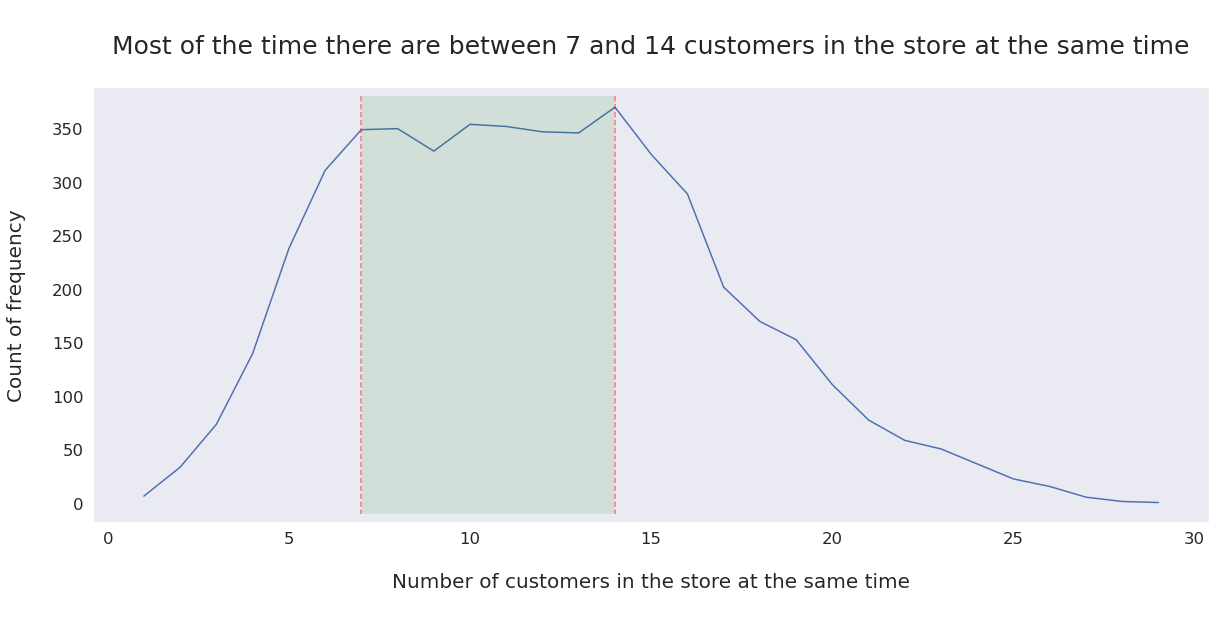

In [679]:
fig = plt.gcf()
fig.set_size_inches(20,8)
p = sns.lineplot(data=df['current_customers'].value_counts())
p.set_xlabel("\nNumber of customers in the store at the same time\n", fontsize = 20)
p.set_ylabel("Count of frequency\n", fontsize = 20)
line1 = plt.axvline(7, 0.98,0.02, color='red', linestyle="--", alpha=0.5)
line2 = plt.axvline(14,0.98,0.02, color='red', linestyle="--", alpha=0.5)
line3 = plt.axvline(10.5,0.98,0.02, color='green', alpha=0.1, linewidth=252, linestyle="--")
p.set_title('\nMost of the time there are between 7 and 14 customers in the store at the same time\n', fontsize = 25);

### Our business managers think that the first section customers visit follows a different pattern than the following ones. Plot the distribution of customers of their first visited section versus following sections (treat all sections visited after the first as “following”).

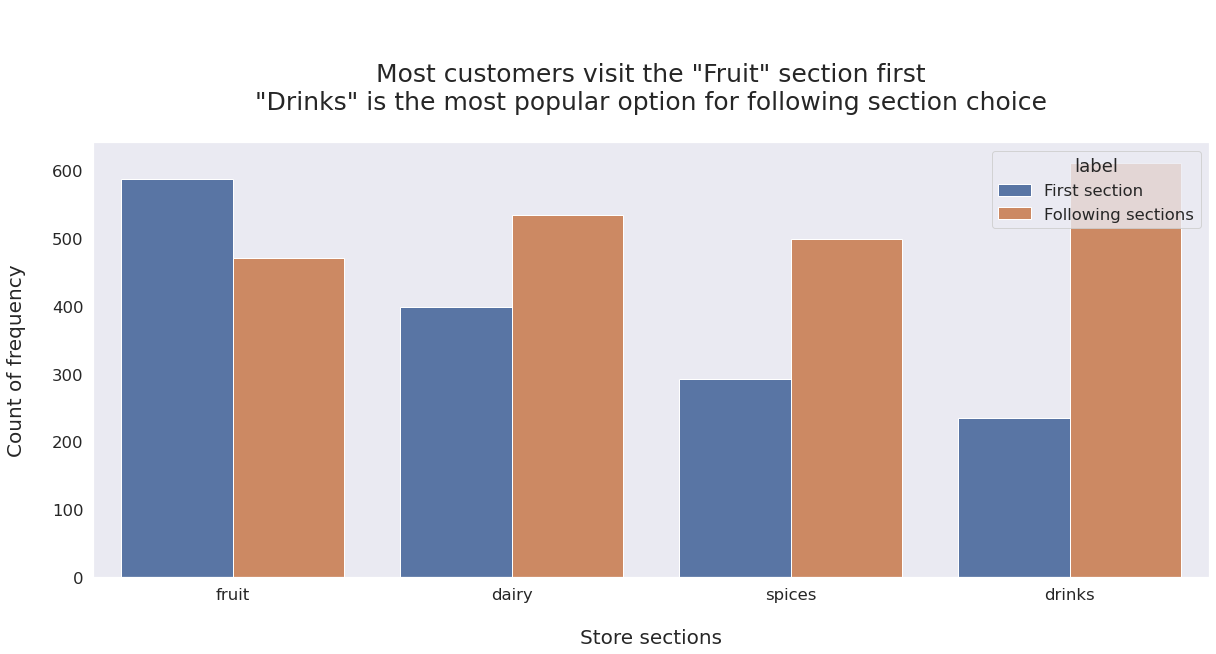

In [697]:
first_section_vc = df.groupby('customer_no').first()['location'].value_counts()
following_section_vc = df['location'].value_counts() - first_section_vc
following_section_vc.drop('checkout', inplace=True)
first_section_vc = pd.DataFrame(first_section_vc, columns=["location", "customers"]).reset_index(level=0)
first_section_vc.columns = ['location', 'customers', 'label']
first_section_vc['label'] = 'First section'
following_section_vc = pd.DataFrame(following_section_vc, columns=["location", "customers"]).reset_index(level=0)
following_section_vc.columns = ['location', 'customers', 'label']
following_section_vc['label'] = 'Following sections'
all_section_vs = pd.concat([first_section_vc, following_section_vc])
fig = plt.gcf()
fig.set_size_inches(20,8)
p = sns.barplot(x="location", y="customers", hue="label", data=all_section_vs)
p.set_xlabel("\nStore sections", fontsize = 20)
p.set_ylabel("Count of frequency\n", fontsize = 20)
p.set_title('\n\nMost customers visit the "Fruit" section first\n"Drinks" is the most popular option for following section choice\n', fontsize = 25);